In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np
np.set_printoptions(suppress=True)

# Pyspark utilities
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)

EXEC_MODE = 1
cloud = False

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

# Start SparkSession to use DataFrames
spark = SparkSession(sc)

22/01/10 16:37:00 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
22/01/10 16:37:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/10 16:37:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Same as above, load a part of the table in memory and use it.
task_events = Table('task_events', sc, EXEC_MODE, cloud)

In [3]:
task_events.pprint(2)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,5611824441,NA,6251812952,1761,1306108,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.07959,0.0003862,1
1,5611824625,NA,6251974185,252,38676295,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.03339,0.0003862,1


In [4]:
task_usage = Table('task_usage', sc, EXEC_MODE, cloud)

In [5]:
# Select first SUBMIT transition for each job
submit_status = task_events.select(['job_id','event_type', 'time'])\
    .filter(lambda x: x[1] in ['0'])\
    .map(lambda x: (x[0], float(x[2])))

rdd_submit = submit_status.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))
rdd_submit.take(5)

[('6231386586', 1517717143.786),
 ('6124898063', 2395664405.97),
 ('6238340468', 1122374427.12),
 ('515042969', 5679343858.806),
 ('6183750753', 1668588991.359)]

In [6]:
# Select first SUBMIT transition for each job
outpending_status = task_events.select(['job_id','event_type', 'time'])\
    .filter(lambda x: x[1] in ['1', '3', '5', '6'])\
    .map(lambda x: (x[0], float(x[2])))

rdd_out = outpending_status.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))
rdd_out.take(5)

[('6252020264', 5635042963.758),
 ('6231386586', 2362823670.556),
 ('4923128384', 659387666.745),
 ('5285926325', 5511499470.333),
 ('6124898063', 3101367995.804)]

In [7]:
rdd_deltatimes = rdd_submit.join(rdd_out).map(lambda x: (x[0], x[1][1] - x[1][0]))

rdd_deltatimes.take(10)

[('6231386586', 845106526.7700002),
 ('6124898063', 705703589.8340001),
 ('6238340468', 4970263.68900013),
 ('515042969', 8406782.13199997),
 ('6183750753', 833950.9440000057),
 ('5664371117', 115256482.102),
 ('515042954', 904311465.6619997),
 ('5921809619', 18412181.374000013),
 ('5390365067', 328432201.199),
 ('6252020538', 2679777.220000267)]

In [ ]:
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, cloud)

In [15]:
# Selects each occurence of constraint registered for each process
task_constraints_per_job = task_constraints.select(['job_id'])\
    .map(lambda x: (x[0],1))\
    .reduceByKey(lambda a,b: a+b)
task_constraints_per_job.take(5)


[('6231386586', 91),
 ('4923128384', 130),
 ('6124898063', 84),
 ('6238340468', 9222),
 ('515042969', 89610)]

In [17]:
# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes.join(task_constraints_per_job).filter(lambda x: x[1][1] < 50)
rdd_delta_constraints.take(5)


[('5390365067', (328432201.199, 20)),
 ('6235196851', (414929.4240000248, 1)),
 ('6252034167', (1452349.0, 3)),
 ('6252038211', (1632035.0, 3)),
 ('6252068151', (1577589.0, 3))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

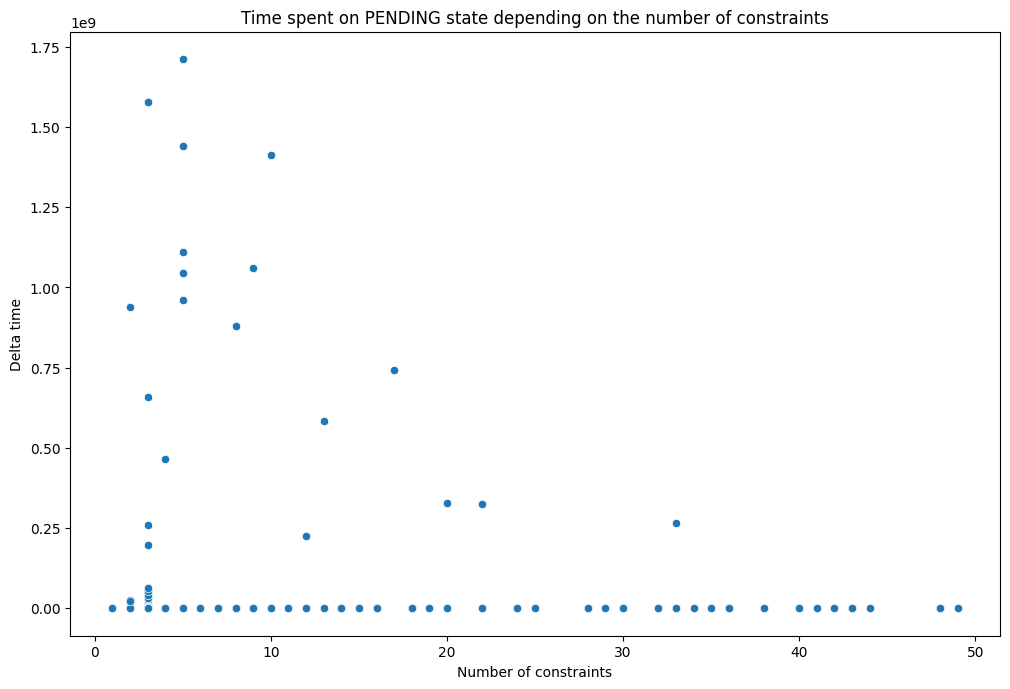

In [18]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")